In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [ ]:
import mailbox
%matplotlib inline
import matplotlib.pyplot as plt
import csv
from textblob import TextBlob
import pandas as pd
import sklearn
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split 
from sklearn import datasets, model_selection, tree
from sklearn.model_selection import learning_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [ ]:
def getmailtext(message):
    body = None
    
    if message.is_multipart():
        for part in message.walk():
            if part.is_multipart():
                for subpart in part.walk():
                    if subpart.get_content_type() == 'text/plain':
                        body = subpart.get_payload(decode=True)
            elif part.get_content_type() == 'text/plain':
                body = part.get_payload(decode=True)
              
    elif message.get_content_type() == 'text/plain':
        body = message.get_payload(decode=True)
   
    mailtext=str(message['subject'])+" "+str(body)
    return mailtext
  

In [ ]:
mbox = mailbox.mbox(('gdrive/My Drive/spam/spam.mbox'))

mlist_spam = []

for message in mbox:
    mlist_spam.append(getmailtext(message))

mbox_ham = mailbox.mbox('gdrive/My Drive/spam/ham.mbox')

mlist_ham = []
count=0

for message in mbox_ham:
    
    mlist_ham.append(getmailtext(message))
    if count>601:
        break
    count+=1

In [ ]:
import pandas as pd
spam_df = pd.DataFrame(mlist_spam, columns=["message"])
spam_df["label"] = "spam"

spam_df['length'] = spam_df['message'].map(lambda text: len(text))
print(spam_df.head())

ham_df = pd.DataFrame(mlist_ham, columns=["message"])
ham_df["label"] = "ham"

ham_df['length'] = ham_df['message'].map(lambda text: len(text))
print(ham_df.head())

                                             message label  length
0  My Dear, b"My Dear,\n\nPlease reply back with ...  spam    4278
1  CAN I TRUST YOU. b"Dear Friend,\n\nThis letter...  spam    3100
2  Fwd: My Dear Friend, b"My Dear Friend,\n\nGood...  spam    2591
3  Getting thinner can be enjoyable b'Anatrim - T...  spam    2081
4  Summer is coming, time to tone up b'Anatrim \x...  spam    2105
                                             message label  length
0  Re: graduate artificial intelligence (AI) cour...   ham    5360
1  (DBWORLD) Future Directions of Database Resear...   ham    4939
2  KDnuggets News 99:24, November 21, 2003 b'\nKD...   ham    4533
3  Re: graduate course invitation b"\nI am still ...   ham    4155
4  Re: Fwd: graduate artificial intelligence (AI)...   ham    4101


In [ ]:
mail_df = pd.concat([spam_df,ham_df])
from sklearn.utils import shuffle
mail_df = shuffle(mail_df)
len(mail_df)

143

In [ ]:
mail_train, mail_test, y_train, y_test = train_test_split(mail_df['message'],mail_df['label'],test_size=0.33, random_state=42)

In [ ]:
def split_into_lemmas(message):
    message = message.lower()
    words = TextBlob(message).words
    return [word.lemma for word in words]

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
def features_transform(mail):
    bow_transformer = CountVectorizer(analyzer=split_into_lemmas).fit(mail_train)
    messages_bow = bow_transformer.transform(mail)
    print('sparse matrix shape:', messages_bow.shape)
    print('number of non-zeros:', messages_bow.nnz) 
    print('sparsity: %.2f%%' % (100.0 * messages_bow.nnz / (messages_bow.shape[0] * messages_bow.shape[1])))
    tfidf_transformer = TfidfTransformer().fit(messages_bow)
    messages_tfidf = tfidf_transformer.transform(messages_bow)
    return messages_tfidf

In [ ]:
train_features=features_transform(mail_train)

sparse matrix shape: (95, 3953)
number of non-zeros: 9601
sparsity: 2.56%


In [ ]:
def model_assessment(y_test,predicted_class):
    print('confusion matrix')
    print(confusion_matrix(y_test,predicted_class))
    print('accuracy')
    print(accuracy_score(y_test,predicted_class))
    print('precision')
    print(precision_score(y_test,predicted_class,pos_label='spam'))
    print('recall')
    print(recall_score(y_test,predicted_class,pos_label='spam'))
    print('f-Score')
    print(f1_score(y_test,predicted_class,pos_label='spam'))
    
    plt.matshow(confusion_matrix(y_test, predicted_class), cmap=plt.cm.binary, interpolation='nearest')
    plt.title('confusion matrix')
    plt.colorbar()
    plt.ylabel('expected label')
    plt.xlabel('predicted label')

In [ ]:
modelNB=MultinomialNB()

In [ ]:
modelNB.fit(train_features,y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [ ]:
test_features=features_transform(mail_test)

sparse matrix shape: (48, 3953)
number of non-zeros: 2773
sparsity: 1.46%


In [ ]:
predicted_class_NB=modelNB.predict(test_features)

confusion matrix
[[ 4 17]
 [ 0 27]]
accuracy
0.6458333333333334
precision
0.6136363636363636
recall
1.0
f-Score
0.7605633802816901


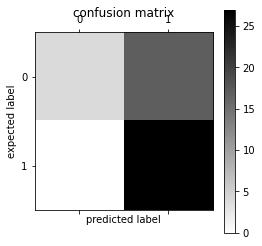

In [ ]:
model_assessment(y_test,predicted_class_NB)


In [ ]:
model_tree=DecisionTreeClassifier()

In [ ]:
model_tree.fit(train_features,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
predicted_class_tree=model_tree.predict(test_features)

confusion matrix
[[10 11]
 [ 3 24]]
accuracy
0.7083333333333334
precision
0.6857142857142857
recall
0.8888888888888888
f-Score
0.7741935483870968


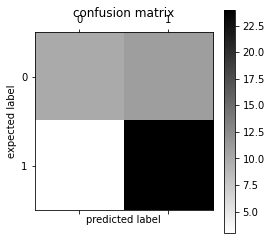

In [ ]:
model_assessment(y_test,predicted_class_tree)